In [1]:
import logging
import numpy as np
import matplotlib.pyplot as plt
import theano
import theano.tensor as T

import theano_shim as shim
import sinn
from sinn.histories import Spiketrain, Series
import sinn.iotools as io
import sinn.analyze as anlz

import main
import fsgif_model as fsgif

import copy

np.set_printoptions(precision=3, suppress=True)
%matplotlib inline

try:
    # Guard against defining multiple loggers
    logger
except NameError:
    rootlogger = logging.getLogger()
    rootlogger.setLevel(sinn.LoggingLevels.MONITOR)

    sthandler = logging.StreamHandler()
    sthandler.setLevel(logging.INFO)
    sthandler.setFormatter(sinn.config.logging_formatter)
    rootlogger.addHandler(sthandler)
    
    filehandler = logging.handlers.RotatingFileHandler(
        'fsgif.log', mode='w', maxBytes=5e5, backupCount=5)
    filehandler.setLevel(sinn.LoggingLevels.MONITOR)
    filehandler.setFormatter(sinn.config.logging_formatter)
    rootlogger.addHandler(filehandler)
    
    logger = logging.getLogger('fsgif')
    logger.setLevel(logging.INFO)

# Data generation

Generate spike trains. If the specified filename already exists, the precomputed data is used instead.

*Note*: Spike trains use relatively fine time bins (0.2&nbsp;ms). This is because spike times must be precise relative to the timescale of the PSP kernel (i.e. $τ_m$).

In [2]:
datalen = 4  # Use 4 seconds of data

spikemodel = main.generate_spikes(datalen,
                                  filename='fsgif_{}s_sin-input_hi-res.dat'.format(datalen))

2017-06-15 14:27:05,908 - root - INFO - Checking for precomputed data...
2017-06-15 14:27:07,070 - root - INFO - Precomputed data found. Skipping data generation


In [3]:
shist = spikemodel.s
spikeIhist = spikemodel.I_ext
true_params = copy.deepcopy(spikemodel.params)
model_params = copy.deepcopy(true_params)

Compute the activity trace by summing over spikes. We subsample the result because the activity trace uses a coarser time bin of 1&nbsp;ms.

*Note*: When subsampling, we average over $n$ bins and combine into one, so we aren't just throwing away 80% of our data.

In [4]:
spikeAhist = Series(shist, name='A', shape=(len(shist.pop_slices),))
summedspikes = np.concatenate(
    [ shist._data.tocsr()[shist.t0idx: shist.t0idx + len(shist), pop_slice].sum(axis=1).A
      for pop_slice in shist.pop_slices ],
    axis=1)
spikeAhist.set(summedspikes / (model_params.N * shist.dt))
spikeAhist.lock()

# Subsample the activity and input
Ahist = anlz.subsample(spikeAhist, np.rint(main.mf_dt / main.spike_dt).astype('int'))
Ahist.lock()
Ihist = anlz.subsample(spikeIhist, np.rint(main.mf_dt / main.spike_dt).astype('int'))
Ihist.lock()

# Remove dependencies of the subsampled data on the original
# (this is to workaround some of sinn's intricacies)
sinn.inputs[Ahist].clear()
sinn.inputs[Ihist].clear()

Plot the generated data.

In [5]:
data = spikemodel.s._data
lineheight = 1
markersize = 1
maxN = None
burnin = 0.0
datalen = 4


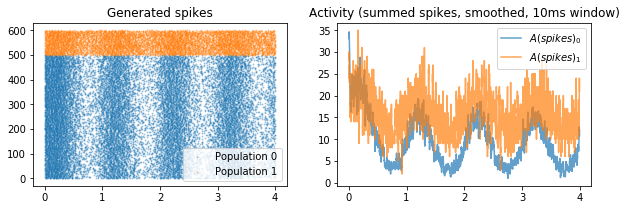

In [6]:
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.title("Generated spikes")
for i, popslice in enumerate(spikemodel.s.pop_slices):
    tarr = spikemodel.s._tarr[data.row]
    tidcs = np.where(np.logical_and(burnin < tarr, tarr < burnin+datalen))[0]
    popidcs = np.where(np.logical_and(popslice.start <= data.col, data.col < popslice.stop))[0]
    idcs = np.intersect1d(tidcs, popidcs)
    plt.scatter(spikemodel.s._tarr[data.row[idcs]], data.col[idcs]*lineheight, 
                s=markersize, linestyle='None', label="Population {}".format(i),
                alpha=0.3)
plt.legend()

plt.subplot(1,2,2)
plt.title("Activity (summed spikes, smoothed, 10ms window)")
anlz.plot(anlz.smooth(Ahist, 10), label='A (spikes)', alpha=0.7)
plt.legend()

In [12]:
sinn.inputs.clear()
mfmodel.history_inputs.clear()

Create the activity model we will fit, with activity trace and input constrained by the spike data.

In [5]:
#spikemodel = fsgif.GIF_spiking(model_params, shist, Ihist, memory_time = memory_time)
mfmodel = main.init_mean_field_model(Ahist,
                                     Ihist,
                                     model_params=model_params)

# Visual validation

To check that the models are consistent, we instantiate a second mean-field model with the same input but let it compute the activity trace. We check that the trace it produces is consistent with the one we will fit to.

In [6]:
mfmodel_unconstrained = main.init_mean_field_model(activity_history = None,
                                                   input_history = Ihist,
                                                   model_params = mfmodel.params)

mfmodel_unconstrained.A.name = 'A (mf)'

In [7]:
mfmodel_unconstrained.A.set()  # Compute A

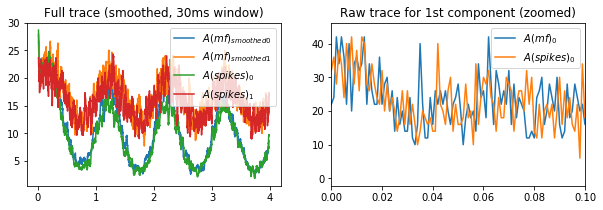

In [9]:
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.title("Full trace (smoothed, 30ms window)")
anlz.plot(anlz.smooth(mfmodel_unconstrained.A, 30))
anlz.plot(anlz.smooth(Ahist, 30), label='A (spikes)')
plt.legend()

plt.subplot(1,2,2)
plt.title("Raw trace for 1st component (zoomed)")
anlz.plot(mfmodel_unconstrained.A, component=0)
anlz.plot(Ahist, label='A (spikes)', component=0)
plt.legend()
plt.xlim((0.0, 0.1))

None

# Likelihood sweep

In [6]:
# Probability is actually computed with number of spikes (n)
# rather than spikes / neuron / s (A).
mfmodel.n.set()
mfmodel.n.lock()

In [7]:
# Workaround for issue with `sinn`
spikemodel.λ.name = 'spikeλ'
spikemodel.u.name = 'spikeu'

In [8]:
main.likelihood_sweep(('w', (0,0)), ('τ_m', (0,)),
                      fineness = (10,2),
                      mean_field_model = mfmodel,
                      output_filename = 'fsgif_loglikelihood_{}s_sin-input.dat'
                                        .format(datalen),
                      recalculate = True)

2017-06-15 14:29:12,579 - root - INFO - Computing log likelihood...
2017-06-15 14:29:12,604 - sinn.sweep - INFO - Evaluating sweep at [-0.5, 0.0030000000000000009]
2017-06-15 14:29:14,387 - sinn.sweep - INFO - Evaluating likelihood function.
2017-06-15 14:30:01,425 - sinn.sweep - INFO - Evaluating sweep at [-0.5, 0.0039004913593761732]
2017-06-15 14:30:03,245 - sinn.sweep - INFO - Evaluating likelihood function.


KeyboardInterrupt: 

Below we plot the unnormalized likelihood. True parameters have non-zero probability (~5x less then the MLE).

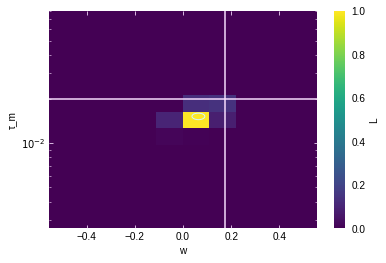

In [10]:
main.plot_likelihood('fsgif_loglikelihood_{}s_sin-input.dat'.format(datalen),
                     ellipse=None,
                     true_params=(true_params.w[0][0],
                                  true_params.τ_m[0]),
                     recalculate=True)

# Model equations

## Spiking model

\begin{gather}
u_{l, i} = \begin{cases}
u_{l-1, i} e^{-Δt/τ_m} + \bigl[u_{rest}^{α(i)} + R I_{ext}^{α(i)}(l) + R I_{syn, i}(l) \bigr]  (1 - e^{-Δt/τ_m}) & \text{if $\hat{t}_i \geq t_{ref}^{α(i)}$} \\
u_{rest}^{α(i)} & \text{otherwise}
\end{cases}
\end{gather}